# Perfect operator for the diffusion equation via a Tensor-Network RG (TTN) in Fourier space

This notebook implements a **tensor-network (tree tensor network / TTN) renormalization** procedure to obtain the **perfect action operator** for the **(1+1)D diffusion equation**, and compares the resulting real-space stencil coefficients to the paper's **Table II** (parameters: **r=1**, **m=0.25**, **κ=2**, lattice **32×32**).

**Key idea:** for this linear (Gaussian) system, the full coarse-grained action is determined by the coarse-grained **two-point function** (structure factor) `S(k,ν) = H(k,ν)^{-1}`. The real-space coarse-graining map is a linear averaging, which in Fourier space becomes a **small tensor** that mixes alias modes. Repeating this map builds a **TTN across scales**, i.e. a tensor-network RG.

> Notes:
> - The code uses only `numpy`, `pandas`, and `matplotlib`.
> - No `quimb` or any PEPS library is required (and you avoid hyper-edge indexing issues).


## 1. What we are computing

In the paper's diffusion example, the (quadratic) action operator has continuum Fourier symbol of the form

\[
H(k,\nu)\ \propto\ \nu^2 + (k^2 + m)^2,
\]

and the perfect (coarse) operator is obtained by integrating out UV degrees of freedom under a space-time coarse graining that keeps

\[
r = \frac{\Delta x^2}{\Delta t}
\]

fixed (so time is coarse-grained twice when space is coarse-grained once). The paper reports the **real-space coefficients** of the perfect operator (Table II) for \(r=1\), \(m=0.25\), and stochastic coarse-graining parameter \(\kappa=2\).

Because the theory is Gaussian, the perfect operator is determined by the perfect structure factor

\[
S(k,\nu) = H(k,\nu)^{-1}.
\]

So our plan is:

1. Start from a very fine UV description (effectively continuum, but on a large discrete grid).
2. Apply **TTN coarse-graining steps** to obtain the coarse-grained \(S(k,\nu)\).
3. Add the (stochastic CG) constant contribution.
4. Invert to get \(H(k,\nu)\), then inverse FFT to get the real-space stencil \(H(t,x)\).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, suppress=True)

## 2. Parameters and the paper's Table II (ground truth)

We'll hard-code the Table II coefficients (t=0..2, x=0..10) from the paper for comparison.


In [2]:
# Parameters used in Table II of the paper
Nx_target, Nt_target = 32, 32
r = 1.0
m_target = 0.25
kappa = 2.0

# Table II coefficients H(t,x) (paper)
H_table = {
    (0,0): 4.00869,
    (0,1): -1.00198,
    (0,2): -0.0819891,
    (0,3): 0.0724608,
    (0,4): 0.0270167,
    (0,5): 3.546940e-4,
    (0,6): -0.002564,
    (0,7): -7.593954e-4,
    (0,8): 4.298800e-5,
    (0,9): 8.703907e-5,
    (0,10): 1.817881e-5,
    (1,0): -0.430984,
    (1,1): -0.265854,
    (1,2): -0.046095,
    (1,3): 0.021651,
    (1,4): 0.012848,
    (1,5): 0.001211,
    (1,6): -0.001157,
    (1,7): -4.724628e-4,
    (1,8): -6.542402e-6,
    (1,9): 4.851149e-5,
    (1,10): 1.406475e-5,
    (2,0): 3.220461e-4,
    (2,1): -2.491026e-4,
    (2,2): -5.120127e-4,
    (2,3): 1.844663e-4,
    (2,4): 5.223556e-4,
    (2,5): 2.386099e-4,
    (2,6): -2.442266e-5,
    (2,7): -5.894465e-5,
    (2,8): -1.676697e-5,
    (2,9): 3.755505e-6,
    (2,10): 4.507152e-6,
}


## 3. UV (fine-grid) structure factor

We work with the **dimensionless** structure factor

\[
S(k,\nu) = \frac{1}{\Delta x^4}\, H(k,\nu)^{-1},
\]

so that \(H\Delta x^4\) is dimensionless (this is the object tabulated in Table II).

For the diffusion example (with \(r\) held fixed), the continuum symbol in these dimensionless variables is

\[
S_{\rm cont}(k,\nu) = \frac{1}{(k^2+m)^2 + r^2 \nu^2},
\qquad k,\nu \in (-\pi,\pi).
\]

We evaluate this on a **large discrete grid** (our UV cutoff), then TTN-coarse-grain down to the target 32×32 grid.


In [3]:
def continuum_S_kw(Nx, Nt, m_dimless, r=1.0):
    """Continuum dimensionless structure factor S(k,nu) on a discrete FFT grid."""
    k = 2*np.pi*np.fft.fftfreq(Nx)   # dimensionless k in [-pi, pi)
    nu = 2*np.pi*np.fft.fftfreq(Nt) # dimensionless nu in [-pi, pi)
    K, NU = np.meshgrid(k, nu, indexing='ij')
    denom = (K**2 + m_dimless)**2 + (r*NU)**2
    return 1.0 / denom


## 4. The tensor-network RG step in Fourier space

### 4.1 Real-space averaging is a small Fourier-space tensor

Define one (hard) coarse-graining step in 1D as

\[
\bar f_n = \frac{1}{2}(f_{2n} + f_{2n+1}).
\]

In Fourier space, downsampling mixes two alias modes \(p\) and \(p+\pi\).
The averaging corresponds to a **2-component tensor** (a TTN isometry) with entries

\[
B(p) = \frac{1+e^{ip}}{2},
\qquad |B(p)|^2 = \cos^2\left(\frac{p}{2}\right).
\]

For a translation-invariant Gaussian theory where modes are uncorrelated,
the structure factor transforms as a **tensor contraction** over the alias index:

\[
S'(k) = \sum_{a\in\{0,1\}} |B(p_a)|^2\, S(p_a).
\]

### 4.2 Magnification scaling (important!)

After coarse graining by 2 in space and 4 in time, the lattice spacing changes as \(\Delta x \to 2\Delta x\).
Since \(S = H^{-1}/\Delta x^4\), the **dimensionless** structure factor rescales by

\[
S \to \frac{S}{16}.
\]

This factor is crucial to match the paper's normalization.

### 4.3 Diffusion scaling: time blocks twice per space block

To keep \(r=\Delta x^2/\Delta t\) fixed, we coarse-grain time **twice** (Nt→Nt/4) for each space coarse graining (Nx→Nx/2).


In [4]:
def block2_axis(S, axis):
    """Hard CG (average of 2 neighbors) along 'axis' in Fourier space."""
    S = np.asarray(S)
    N = S.shape[axis]
    assert N % 2 == 0
    Nc = N // 2

    p = 2*np.pi*np.fft.fftfreq(N)
    B = 0.5 * (1.0 + np.exp(1j*p))
    w = (B.conj() * B).real  # |B|^2 = cos^2(p/2)

    # pair indices i and i+Nc (FFT ordering)
    sl0 = [slice(None)] * S.ndim
    sl1 = [slice(None)] * S.ndim
    sl0[axis] = slice(0, Nc)
    sl1[axis] = slice(Nc, N)
    S0 = S[tuple(sl0)]
    S1 = S[tuple(sl1)]

    shp = [1]*S.ndim
    shp[axis] = Nc
    w0 = w[:Nc].reshape(shp)
    w1 = w[Nc:].reshape(shp)

    return w0*S0 + w1*S1


def rg_step_diffusion(S):
    """One TTN RG step: time /2 twice, space /2 once, then magnification scaling /16."""
    S1 = block2_axis(S, axis=1)  # time /2
    S2 = block2_axis(S1, axis=1) # time /2 again -> /4
    S3 = block2_axis(S2, axis=0) # space /2
    return S3 / 16.0


def iterate_rg(S0, nsteps):
    S = S0
    for _ in range(nsteps):
        S = rg_step_diffusion(S)
    return S


## 5. Run the TTN RG and show convergence to Table II

`nsteps` controls how many fine scales you integrate out before reaching the target 32×32 lattice.

Larger `nsteps` → closer to the true perfect operator (the effective averaging filter approaches a sinc).


In [5]:
def H_from_S(S_hard, r=1.0, kappa=2.0):
    """Add stochastic CG noise term and invert to get H(k,nu)."""
    # stochastic CG adds a constant to S(k,nu) (paper's diffusion example)
    noise = 1.0 / (3.0 * (r**2) * kappa)
    S_soft = S_hard + noise
    return 1.0 / S_soft


def realspace_coeffs_from_H(H_kw):
    """Inverse FFT to get real-space stencil H(x,t)."""
    return np.fft.ifft2(H_kw).real


def compare_to_paper(H_xt, H_table):
    rows = []
    for (t,x), val in sorted(H_table.items()):
        pred = H_xt[x % H_xt.shape[0], t % H_xt.shape[1]]
        rows.append((t, x, val, pred, pred - val))
    df = pd.DataFrame(rows, columns=["t", "x", "paper", "tn", "diff"])
    rmse = float(np.sqrt(np.mean(df["diff"]**2)))
    maxerr = float(np.max(np.abs(df["diff"])))
    return df, rmse, maxerr


for nsteps in range(1, 5):
    Nx0 = Nx_target * (2**nsteps)
    Nt0 = Nt_target * (4**nsteps)
    m0 = m_target / (4**nsteps)   # physical m fixed while dx shrinks

    S0 = continuum_S_kw(Nx0, Nt0, m0, r=r)
    S_coarse = iterate_rg(S0, nsteps)

    H_kw = H_from_S(S_coarse, r=r, kappa=kappa)
    H_xt = realspace_coeffs_from_H(H_kw)

    df, rmse, maxerr = compare_to_paper(H_xt, H_table)
    print(f"nsteps={nsteps}  RMSE={rmse:.3e}  max|err|={maxerr:.3e}  H(0,0)={H_xt[0,0]:.6f}")

nsteps=1  RMSE=1.184e-02  max|err|=6.522e-02  H(0,0)=3.943471
nsteps=2  RMSE=2.225e-03  max|err|=1.204e-02  H(0,0)=3.996653
nsteps=3  RMSE=5.058e-04  max|err|=2.693e-03  H(0,0)=4.005997
nsteps=4  RMSE=1.235e-04  max|err|=6.544e-04  H(0,0)=4.008036


## 6. Final comparison (pick a sufficiently fine RG depth)

We'll use `nsteps=4` (already very accurate) and print a comparison table.


In [11]:
nsteps = 6
Nx0 = Nx_target * (2**nsteps)
Nt0 = Nt_target * (4**nsteps)
m0 = m_target / (4**nsteps)

S0 = continuum_S_kw(Nx0, Nt0, m0, r=r)
S_coarse = iterate_rg(S0, nsteps)

H_kw = H_from_S(S_coarse, r=r, kappa=kappa)
H_xt = realspace_coeffs_from_H(H_kw)

df, rmse, maxerr = compare_to_paper(H_xt, H_table)
display(df)
print("RMSE:", rmse)
print("max|err|:", maxerr)

,t,x,paper,tn,diff
0,0,0,4.008690,4.008647,-4.265401e-05
1,0,1,-1.001980,-1.001967,1.345229e-05
2,0,2,-0.081989,-0.081980,9.340127e-06
3,0,3,0.072461,0.072459,-1.832530e-06
4,0,4,0.027017,0.027015,-1.421866e-06
5,0,5,0.000355,0.000355,1.848165e-08
6,0,6,-0.002564,-0.002564,-3.341482e-08
7,0,7,-0.000759,-0.000760,-1.050419e-07
8,0,8,0.000043,0.000044,5.546564e-07
9,0,9,0.000087,0.000090,3.129319e-06


RMSE: 8.119556075080068e-06
max|err|: 4.265401012037984e-05


### Optional: visualize the errors vs (t,x)

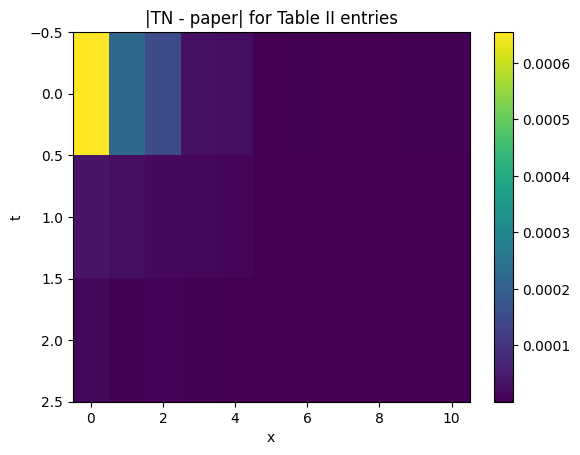

In [7]:
# Make a small grid plot of the absolute error for t=0..2, x=0..10
err = np.zeros((3, 11))
for (t,x), val in H_table.items():
    pred = H_xt[x, t]
    err[t, x] = abs(pred - val)

plt.figure()
plt.imshow(err, aspect='auto')
plt.xlabel("x")
plt.ylabel("t")
plt.title("|TN - paper| for Table II entries")
plt.colorbar()
plt.show()

## 7. Dispersion relation check (optional)

The paper extracts the mode decay rate (dispersion) from the real-time structure factor \(S(k,t)\) using two early time points,
roughly

\[
v(k) \approx \ln\frac{S(k,\Delta t)}{S(k,2\Delta t)}.
\]

For diffusion, the exact continuum decay is \(v(k)=m+k^2\).
We'll compute \(S(k,t)\) by inverse FFT of the (hard) structure factor over frequency and compare \(v(k)\) to \(m+k^2\).


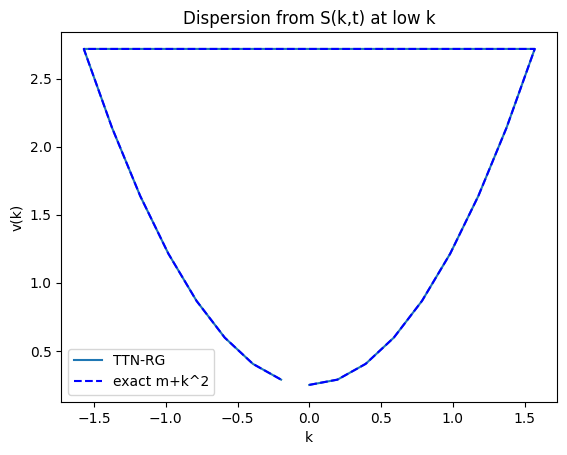

max |v_est - v_exact| on |k|<=pi/2: 0.0003585347118690574


In [9]:
def dispersion_from_Skw(S_kw):
    S_kt = np.fft.ifft(S_kw, axis=1).real  # inverse FFT over nu -> t
    v = np.log(S_kt[:, 1] / S_kt[:, 2])    # dt=1 in these dimensionless units
    return v, S_kt

v_est, S_kt = dispersion_from_Skw(S_coarse)

k = 2*np.pi*np.fft.fftfreq(Nx_target)
v_exact = k**2 + m_target

# focus on low-k where continuum should be most accurate
mask = np.abs(k) <= np.pi/2

plt.figure()
plt.plot(k[mask], v_est[mask], label="TTN-RG")
plt.plot(k[mask], v_exact[mask], 'b--', label="exact m+k^2")
plt.xlabel("k")
plt.ylabel("v(k)")
plt.title("Dispersion from S(k,t) at low k")
plt.legend()
plt.show()

print("max |v_est - v_exact| on |k|<=pi/2:", np.max(np.abs(v_est[mask] - v_exact[mask])))

## 8. What to take away (and why this is a tensor-network method)

- Each blocking step is a **local 2-to-1 isometry** (a small tensor) that maps fine modes to coarse modes by mixing two aliases.
- Repeating those tensors across scales forms a **tree tensor network (TTN)**.
- Because diffusion here is **Gaussian**, the RG closes on the 2-point function, so the entire perfect action is recovered by TTN contraction + inversion.
- For nonlinear PDEs, the same idea remains (coarse-grain the full distribution), but you need an approximate representation of the non-Gaussian measure (e.g., discretize fields and use TRG/HOTRG/TNR or variational TTN/MERA).

If you'd like, the next step is to replace the Gaussian `S0` with a **measured** (Monte-Carlo) structure factor on a fine lattice and run the same TTN coarse-graining to infer an effective coarse operator numerically.
